In [1]:
# In this noteboook
# We will be perturbing the top 3 PCs of the PATTERNS image embeddings
# And reconstructing perturbed images via StableDiffusion 
# In an endeavor to interpret those 3 dimensions and what they encode
# Pipeline designed by Nandini

In [2]:
!pip install --upgrade diffusers[torch]
!pip install diffusers
!pip install transformers
!pip install torch

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Imports

In [1]:
import os
from pathlib import Path

In [2]:
import requests
import torch
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
import numpy as np
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec

In [3]:
from diffusers import StableUnCLIPImg2ImgPipeline
from transformers import CLIPTextModelWithProjection, CLIPTokenizer

2025-12-06 03:28:58.371174: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-06 03:28:58.371270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-06 03:28:58.372776: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-06 03:28:58.384486: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading CLIP Embeddings

In [4]:
base_dir = '/home/n2ortega/'

In [5]:
# Loading pre-generated CLIP embeddings from PATTERNS
patterns_emb = np.load('patterns_emb.npy')

In [6]:
# We first visualize what each of the original embeddings look like in the PC space where n_components =3
pca_patterns = PCA(n_components=3)
patterns_pca = pca_patterns.fit_transform(patterns_emb)

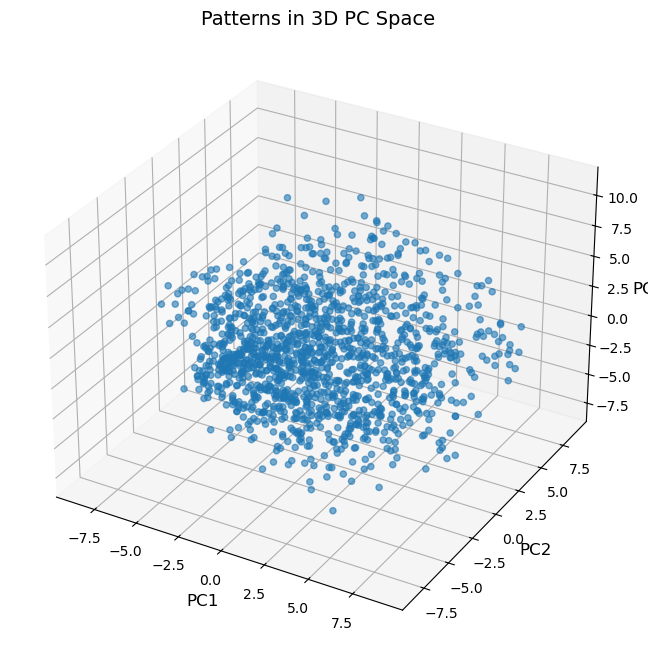

In [7]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(patterns_pca[:, 0], patterns_pca[:, 1], patterns_pca[:, 2], alpha=0.6)
ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
ax.set_zlabel('PC3', fontsize=12)
ax.set_title('Patterns in 3D PC Space', fontsize=14)

plt.show()

## Setting up StableUnCLIP using starter code

In [8]:
torch.cuda.empty_cache()

In [9]:
tqdm._instances.clear()

In [10]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")


In [11]:
recon_pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    "sd2-community/stable-diffusion-2-1-unclip", torch_dtype=torch.float32
)

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

In [12]:
#recon_pipe = recon_pipe.to("cuda")
recon_pipe = recon_pipe.to(device)

In [14]:
def reconstruct_image_from_embedding(recon_pipe, embedding):
    emb_tensor = torch.from_numpy(embedding).unsqueeze(0).to(
        device=recon_pipe.device, 
        dtype=recon_pipe.image_encoder.dtype
    )
    return recon_pipe(image_embeds=emb_tensor).images[0]

## Setting up perturbation and reconstruction

In [15]:
random_idx = np.random.choice(len(patterns_emb))
original_emb = patterns_emb[random_idx]

print(f"Selected image at index: {random_idx}")
print(f"Embedding shape: {original_emb.shape}") 

Selected image at index: 1091
Embedding shape: (1024,)


In [16]:
def get_all_images_pathlib(root_folder):
    root_path = Path(root_folder)
    images = []
    
    for file_path in root_path.rglob('*'):
        if file_path.suffix.lower() == '.jpg':
            images.append(str(file_path))
    
    return images

In [17]:
patterns_folder = f'{base_dir}COGS118B_FinalProject/Patterns'
patterns = get_all_images_pathlib(patterns_folder)

original_img = patterns[random_idx]
print(original_img)

/home/n2ortega/COGS118B_FinalProject/Patterns/scaly/scaly_0147.jpg


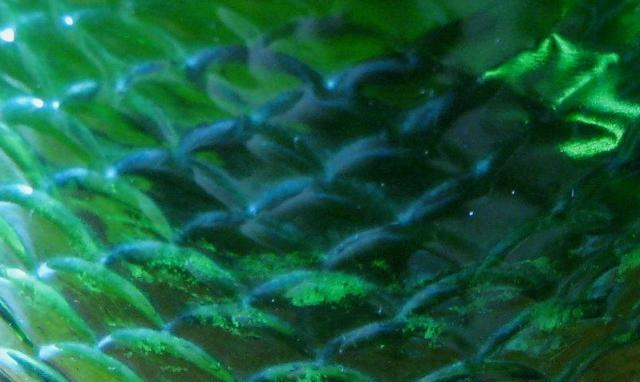

In [18]:
image_path = patterns[random_idx]
img = Image.open(image_path)
display(img)

## Exploring Perturbation along PC1

In [19]:
pc1_direction = pca_patterns.components_[0]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

KeyboardInterrupt: 

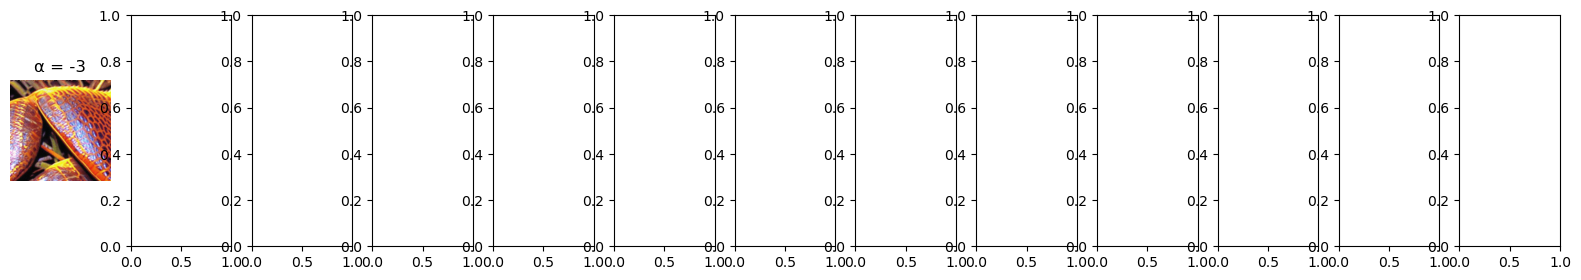

In [20]:
alphas = [-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]
fig, axes = plt.subplots(1, len(alphas), figsize=(20, 3))

for i, alpha in enumerate(alphas):
    perturbed_emb = original_emb + alpha * pc1_direction
    reconstructed = reconstruct_image_from_embedding(recon_pipe, perturbed_emb)
    
    axes[i].imshow(reconstructed)
    axes[i].set_title(f'α = {alpha}')
    axes[i].axis('off')

plt.suptitle('Perturbations along PC1')
plt.tight_layout()
plt.show()

In [ ]:
# Changing the scale of alphas to try larger perturbations
alphas = [-20, -10, -5, -2, 0, 2, 5, 10, 20]
fig, axes = plt.subplots(1, len(alphas), figsize=(20, 3))

for i, alpha in enumerate(alphas):
    perturbed_emb = original_emb + alpha * pc1_direction
    reconstructed = reconstruct_image_from_embedding(recon_pipe, perturbed_emb)
    
    axes[i].imshow(reconstructed)
    axes[i].set_title(f'α = {alpha}')
    axes[i].axis('off')

plt.suptitle('Perturbations along PC1')
plt.tight_layout()
plt.show()

In [ ]:
# Changing the scale of alphas to try even larger perturbations
alphas = [-50, -20, -10, -5, 0, 5, 10, 20, 50]
fig, axes = plt.subplots(1, len(alphas), figsize=(20, 3))

for i, alpha in enumerate(alphas):
    perturbed_emb = original_emb + alpha * pc1_direction
    reconstructed = reconstruct_image_from_embedding(recon_pipe, perturbed_emb)
    
    axes[i].imshow(reconstructed)
    axes[i].set_title(f'α = {alpha}')
    axes[i].axis('off')

plt.suptitle('Perturbations along PC1')
plt.tight_layout()
plt.show()

## Perturbation along PC2

In [ ]:
pc2_direction = pca_patterns.components_[1]

In [ ]:
alphas = [-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]
fig, axes = plt.subplots(1, len(alphas), figsize=(20, 3))

for i, alpha in enumerate(alphas):
    perturbed_emb = original_emb + alpha * pc2_direction
    reconstructed = reconstruct_image_from_embedding(recon_pipe, perturbed_emb)
    
    axes[i].imshow(reconstructed)
    axes[i].set_title(f'α = {alpha}')
    axes[i].axis('off')

plt.suptitle('Perturbations along PC2')
plt.tight_layout()
plt.show()

In [ ]:
# Changing the scale of alphas to try larger perturbations
alphas = [-20, -10, -5, -2, 0, 2, 5, 10, 20]
fig, axes = plt.subplots(1, len(alphas), figsize=(20, 3))

for i, alpha in enumerate(alphas):
    perturbed_emb = original_emb + alpha * pc2_direction
    reconstructed = reconstruct_image_from_embedding(recon_pipe, perturbed_emb)
    
    axes[i].imshow(reconstructed)
    axes[i].set_title(f'α = {alpha}')
    axes[i].axis('off')

plt.suptitle('Perturbations along PC2')
plt.tight_layout()
plt.show()

In [ ]:
# Changing the scale of alphas to try even larger perturbations
alphas = [-50, -20, -10, -5, 0, 5, 10, 20, 50]
fig, axes = plt.subplots(1, len(alphas), figsize=(20, 3))

for i, alpha in enumerate(alphas):
    perturbed_emb = original_emb + alpha * pc2_direction
    reconstructed = reconstruct_image_from_embedding(recon_pipe, perturbed_emb)
    
    axes[i].imshow(reconstructed)
    axes[i].set_title(f'α = {alpha}')
    axes[i].axis('off')

plt.suptitle('Perturbations along PC2')
plt.tight_layout()
plt.show()

## Perturbation along PC3

In [ ]:
pc3_direction = pca_patterns.components_[2]

In [ ]:
alphas = [-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]
fig, axes = plt.subplots(1, len(alphas), figsize=(20, 3))

for i, alpha in enumerate(alphas):
    perturbed_emb = original_emb + alpha * pc3_direction
    reconstructed = reconstruct_image_from_embedding(recon_pipe, perturbed_emb)
    
    axes[i].imshow(reconstructed)
    axes[i].set_title(f'α = {alpha}')
    axes[i].axis('off')

plt.suptitle('Perturbations along PC3')
plt.tight_layout()
plt.show()

In [ ]:
# Changing the scale of alphas to try larger perturbations
alphas = [-20, -10, -5, -2, 0, 2, 5, 10, 20]
fig, axes = plt.subplots(1, len(alphas), figsize=(20, 3))

for i, alpha in enumerate(alphas):
    perturbed_emb = original_emb + alpha * pc3_direction
    reconstructed = reconstruct_image_from_embedding(recon_pipe, perturbed_emb)
    
    axes[i].imshow(reconstructed)
    axes[i].set_title(f'α = {alpha}')
    axes[i].axis('off')

plt.suptitle('Perturbations along PC3')
plt.tight_layout()
plt.show()

In [ ]:
# Changing the scale of alphas to try even larger perturbations
alphas = [-50, -20, -10, -5, 0, 5, 10, 20, 50]
fig, axes = plt.subplots(1, len(alphas), figsize=(20, 3))

for i, alpha in enumerate(alphas):
    perturbed_emb = original_emb + alpha * pc3_direction
    reconstructed = reconstruct_image_from_embedding(recon_pipe, perturbed_emb)
    
    axes[i].imshow(reconstructed)
    axes[i].set_title(f'α = {alpha}')
    axes[i].axis('off')

plt.suptitle('Perturbations along PC3')
plt.tight_layout()
plt.show()

## Visualizing Perturbations at a High-level

In [ ]:
n_images = 5  # number of different images to analyze
pcs_indices = [0, 1, 2]

# set 
alphas = [-50, -40, -30, -20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20, 30, 40, 50]

In [ ]:
# Randomly selecting imgs for perturbation+reconstruction
random_indices = np.random.choice(len(patterns_emb), size=n_images, replace=False)

In [ ]:
for img_num, idx in enumerate(random_indices):
    original_emb = patterns_emb[idx]
    original_img = Image.open(patterns[idx])
    
    fig = plt.figure(figsize=(20, 8))
    
    gs = gridspec.GridSpec(len(pcs_indices) + 1, len(alphas), 
                          height_ratios=[0.9] + [1]*len(pcs_indices),
                          hspace=0.02, wspace=0.02)

    # showing original img before perturbation
    ax_orig = fig.add_subplot(gs[0, len(alphas)//2 - 1:len(alphas)//2 + 2])
    ax_orig.imshow(original_img)
    ax_orig.axis('off')
    ax_orig.set_title('Original', fontsize=12, pad=5)
    
    # Creating perturbation grid
    for row, pc_idx in enumerate(pcs_indices):
        pc_direction = pca_patterns.components_[pc_idx]
        
        for col, alpha in enumerate(alphas):
            # Perturbing embs
            perturbed_emb = original_emb + alpha * pc_direction
            
            # Reconstructing perturbs imgs
            reconstructed = reconstruct_image_from_embedding(recon_pipe, perturbed_emb)
            
            ax = fig.add_subplot(gs[row + 1, col])
            ax.imshow(reconstructed)
            ax.axis('off')

            if col == 0:
                ax.set_ylabel(f'PC{pc_idx+1}', fontsize=14, rotation=0, labelpad=30)
            if row == 0:
                ax.set_title(f'α={alpha}', fontsize=10)
    
    plt.suptitle(f'Image {img_num+1}: Perturbations along PC1, PC2, PC3', 
                 fontsize=16, y=0.99)
    plt.show()